In [1]:
!pip install nba_api

In [2]:
from nba_api.stats.endpoints import (
    LeagueGameFinder, BoxScoreAdvancedV2, PlayerCareerStats,
    PlayerDashboardByYearOverYear, TeamPlayerDashboard,
    LeagueDashPlayerStats, LeagueLineupViz, LeagueDashTeamStats,
    TeamPlayerOnOffDetails
)
import pandas as pd
import time

In [3]:
# Function to fetch league-wide player stats
def fetch_player_stats(season='2023-24'):
    print("Fetching player stats...")
    player_stats = LeagueDashPlayerStats(season=season).get_data_frames()[0]
    player_stats = player_stats[['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'GP', 'MIN', 'PTS', 'AST', 'REB', 'STL', 'BLK', 'TOV', 'PLUS_MINUS']]
    return player_stats

# Function to fetch team stats
def fetch_team_stats(season='2023-24'):
    print("Fetching team stats...")
    team_stats = LeagueDashTeamStats(season=season).get_data_frames()[0]
    team_stats = team_stats[['TEAM_ID', 'TEAM_NAME', 'GP', 'W', 'L']]
    return team_stats

# Function to fetch lineup data
def fetch_lineup_data(season='2023-24'):
    print("Fetching lineup data...")
    lineup_data = LeagueLineupViz(season=season, minutes_min=30).get_data_frames()[0]
    lineup_data = lineup_data[['GROUP_ID', 'GROUP_NAME', 'TEAM_ID' , 'OFF_RATING', 'DEF_RATING', 'NET_RATING']]
    return lineup_data

# Function to fetch BoxScoreAdvancedV2 data for a specific game
def fetch_advanced_boxscore(game_id):
    print(f"Fetching advanced box score for game {game_id}...")
    boxscore = BoxScoreAdvancedV2(game_id=game_id).get_data_frames()[0]

    # Selecting relevant advanced stats
    boxscore = boxscore[['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'PLAYER_NAME', 'OFF_RATING', 'DEF_RATING', 'USG_PCT', 'AST_RATIO', 'TS_PCT', 'PIE']]
    return boxscore

# Function to fetch game IDs (to use with BoxScoreAdvancedV2)
def fetch_game_ids(season='2023-24', team_id=None):
    print("Fetching recent game IDs...")
    game_finder = LeagueGameFinder(season_nullable=season, team_id_nullable=team_id)
    games = game_finder.get_data_frames()[0]

    # Return the most recent 10 games
    return games['GAME_ID'].unique()

In [4]:
# Function to clean and merge data
def clean_and_merge_data():
    player_stats = fetch_player_stats()
    team_stats = fetch_team_stats()
    lineup_data = fetch_lineup_data()

    # Fetch BoxScoreAdvancedV2 for recent games
    game_ids = fetch_game_ids()
    all_boxscores = []
    for game_id in game_ids:
        time.sleep(1)  # Prevent API rate limits
        try:
            boxscore = fetch_advanced_boxscore(game_id)
            all_boxscores.append(boxscore)
        except:
            print(f"Skipping game {game_id} due to API error.")

    # Combine all box scores
    if all_boxscores:
        boxscore_df = pd.concat(all_boxscores, ignore_index=True)
    else:
        boxscore_df = pd.DataFrame()

    # Merge player stats with team stats
    df = player_stats.merge(team_stats, on='TEAM_ID', how='left')

    # Merge lineup data
    df = df.merge(lineup_data, on='TEAM_ID', how='left')

    # Merge advanced box score data
    if not boxscore_df.empty:
        df = df.merge(boxscore_df, on=['PLAYER_ID', 'TEAM_ID'], how='left')

    # Drop duplicates and NaN values
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)

    # Normalize per-minute stats
    df['PTS_per_MIN'] = df['PTS'] / df['MIN']
    df['AST_per_MIN'] = df['AST'] / df['MIN']
    df['REB_per_MIN'] = df['REB'] / df['MIN']
    df['STL_per_MIN'] = df['STL'] / df['MIN']
    df['BLK_per_MIN'] = df['BLK'] / df['MIN']
    df['TOV_per_MIN'] = df['TOV'] / df['MIN']

    # Drop old columns
    df.drop(columns=['PTS', 'AST', 'REB', 'STL', 'BLK', 'TOV', 'MIN'], inplace=True)

    return df

In [ ]:
# Main function to execute data pipeline
def main():
    df = clean_and_merge_data()

    # Save the cleaned dataset
    csv_filename = "nba_lineup_data.csv"
    df.to_csv(csv_filename, index=False)
    print(f"Data saved to {csv_filename}")

if __name__ == "__main__":
    main()

Fetching player stats...
Fetching team stats...
Fetching lineup data...
Fetching recent game IDs...
Fetching advanced box score for game 0042300405...
Fetching advanced box score for game 0042300404...
Fetching advanced box score for game 0042300403...
Fetching advanced box score for game 0042300402...
Fetching advanced box score for game 0042300401...
Fetching advanced box score for game 0042300315...
Fetching advanced box score for game 0042300314...
Fetching advanced box score for game 0042300304...
Fetching advanced box score for game 0042300313...
Fetching advanced box score for game 0042300303...
Fetching advanced box score for game 0042300312...
Fetching advanced box score for game 0042300302...
Fetching advanced box score for game 0042300311...
Fetching advanced box score for game 0042300301...
Fetching advanced box score for game 0042300217...
Fetching advanced box score for game 0042300237...
Fetching advanced box score for game 0042300226...
Fetching advanced box score for g

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned data
df = pd.read_csv("nba_lineup_data.csv")

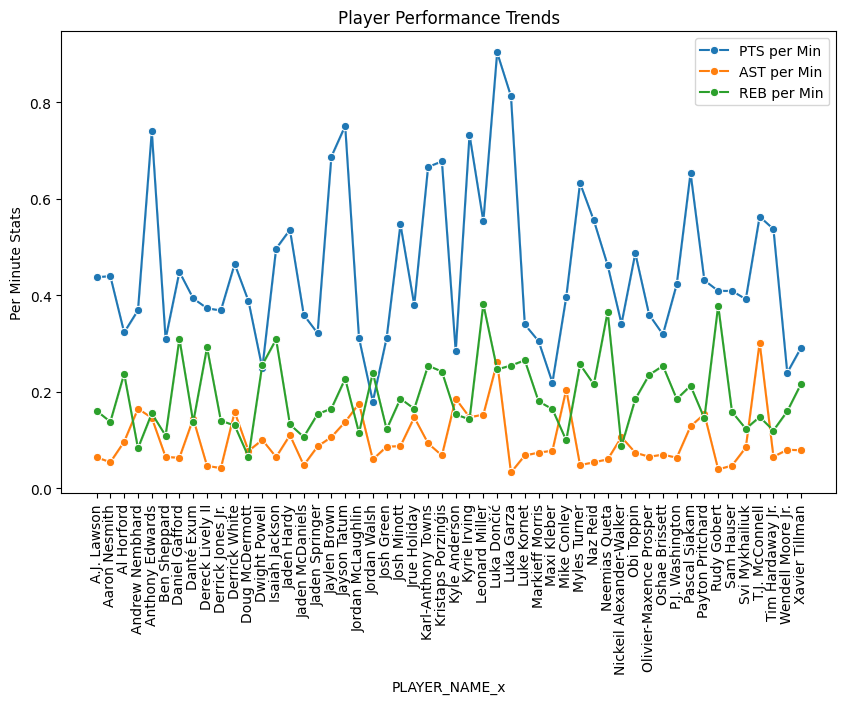

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="PLAYER_NAME_x", y="PTS_per_MIN", label="PTS per Min", marker="o")
sns.lineplot(data=df, x="PLAYER_NAME_x", y="AST_per_MIN", label="AST per Min", marker="o")
sns.lineplot(data=df, x="PLAYER_NAME_x", y="REB_per_MIN", label="REB per Min", marker="o")
plt.xticks(rotation=90)
plt.ylabel("Per Minute Stats")
plt.title("Player Performance Trends")
plt.legend()
plt.show()

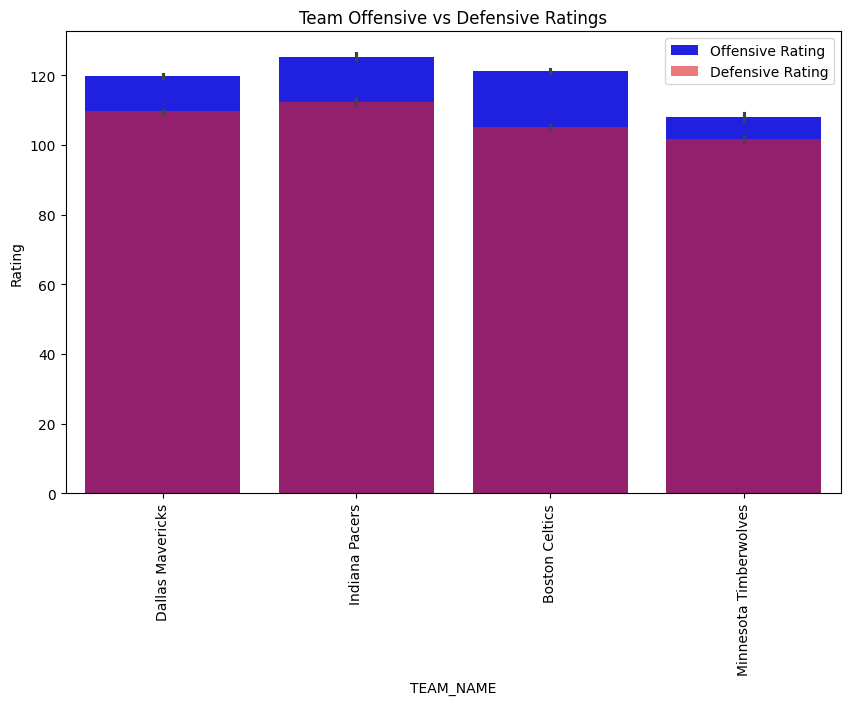

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="TEAM_NAME", y="OFF_RATING_x", color="blue", label="Offensive Rating")
sns.barplot(data=df, x="TEAM_NAME", y="DEF_RATING_x", color="red", alpha=0.6, label="Defensive Rating")
plt.xticks(rotation=90)
plt.ylabel("Rating")
plt.title("Team Offensive vs Defensive Ratings")
plt.legend()
plt.show()


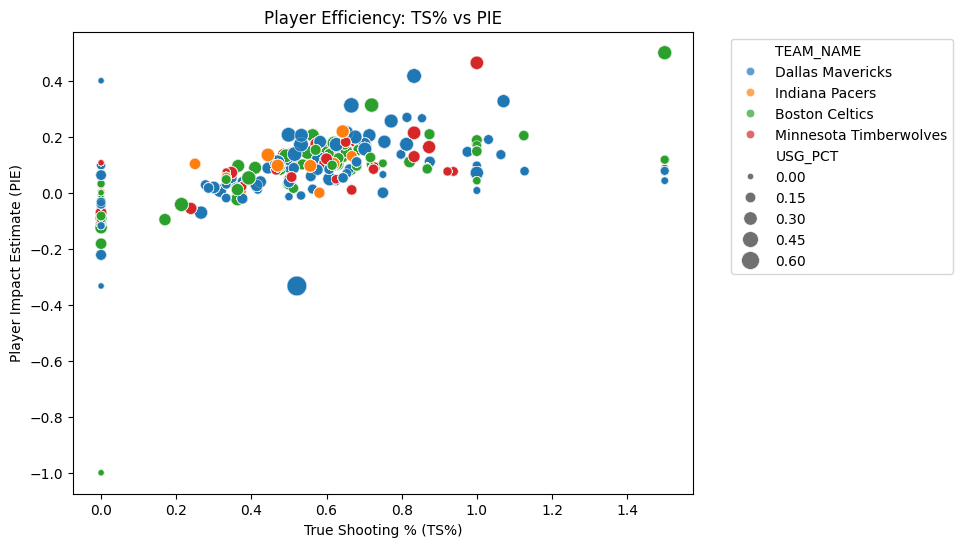

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="TS_PCT", y="PIE", hue="TEAM_NAME", size="USG_PCT", sizes=(20, 200), alpha=0.7)
plt.xlabel("True Shooting % (TS%)")
plt.ylabel("Player Impact Estimate (PIE)")
plt.title("Player Efficiency: TS% vs PIE")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
